# 1. Use SAM for Image Segmentation
# 2. Use Pose Detection to find the pose of the person
# 3. Segment Diffrent parts of the body

# Read From directory

In [24]:
import os

class ReadBuddy:
    def __init__(self, parent_directory):
        self.parent_directory = parent_directory
        

    def create_folder_dictionary(self):
        
        folder_dict = {}
        for folder in os.listdir(self.parent_directory):
            folder_path = os.path.join(self.parent_directory, folder)
            file_array = []
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                file_array.append(file_path)
            folder_dict[folder] = file_array

        return folder_dict


# Detector class

In [21]:
from super_gradients.training import models
import matplotlib.pyplot as plt
import cv2

class DetectBuddy:
    def __init__(self, model_name='yolo_nas_l', weights='coco', conf_threshold=0.8):
        self.model = models.get(model_name, pretrained_weights=weights)
        self.conf_threshold = conf_threshold
        self.detection_list = []
        
    def predict_human(self, image_path_or_array, show=False):
        if isinstance(image_path_or_array, str):
            
            image = cv2.imread(image_path_or_array)
        else:
           
            image = image_path_or_array
            
        prediction = self.model.predict(image, conf=self.conf_threshold)
        
        if show:
            prediction.show()
        
        detection_pred = prediction._images_prediction_lst
        self.detection_list = list(detection_pred)


detect= DetectBuddy()

[2023-07-23 20:53:14] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


# Segmentor class

In [22]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

import sys
sys.path.append("..")
from super_gradients.training import models
from segment_anything import  SamPredictor
import numpy as np
import cv2



class SegmentBuddy():
    
    ##### CODE FROM DOCUMENTATION #####
    def show_mask(mask, ax, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def show_points(coords, labels, ax, marker_size=375):
        pos_points = coords[labels==1]
        neg_points = coords[labels==0]
        ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
        ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

    def show_box(box, ax):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

    def show_anns(anns):
        if len(anns) == 0:
            return
        sorted_anns = sorted(anns, key=lambda x: x['area'], reverse=True)
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        for ann in sorted_anns:
            m = ann['segmentation']
            img = np.ones((m.shape[0], m.shape[1], 3))
            color_mask = np.random.random((1, 3)).tolist()[0]
            for i in range(3):
                img[:, :, i] = color_mask[i]
            ax.imshow(np.dstack((img, m * 0.35)))
            
    ##### CODE FROM DOCUMENTATION #####
    
    
    
    def __init__(self,path_to_checkpoints, model_type="vit_h",device="cuda" if torch.cuda.is_available() else "cpu"):
        
        self.sam = sam_model_registry[model_type] (checkpoint=path_to_checkpoints)
        self.sam.to (device=device)
        
        self.mask_generator = SamAutomaticMaskGenerator (self.sam)
        
        self.predictor = SamPredictor(self.sam)
            
            
    def segment_person(self,image_path,show_mask=False):
        
        
        detect.predict_human(image_path)

        
        detection_list = detect.detection_list

        
        bboxes_xyxy = detection_list[0].prediction.bboxes_xyxy.tolist()
        labels = detection_list[0].prediction.labels.tolist()
        
        image = cv2.imread(image_path)
        
        masks = self.mask_generator.generate(image)

        self.predictor.set_image(image)

        image = image.transpose((2, 0, 1))  # Transpose to match SAM input format
        image = image / 255.0  # Normalize image values to [0, 1]
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        input_box = np.array(bboxes_xyxy[0])
        
        if labels[0] == 0:
           
            masks, _, _ = self.predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )
    
        masked_image = cv2.bitwise_and(image[0].transpose((1, 2, 0)), image[0].transpose((1, 2, 0)), mask=masks[0].astype(np.uint8))
        
        
        if show_mask:
            plt.imshow(image[0].transpose((1, 2, 0)))
            if labels[0] == 0:
                plt.imshow(masks[0], alpha=0.5)
                
       
        return masked_image

        
segmentor=SegmentBuddy("../resources/sam_vit_h_4b8939.pth")       

In [ ]:
segmentor.segment_person("../preprocessed-data/bad_ankel_left/0.jpg",show_mask=True)

# Collab

In [30]:
reader=ReadBuddy("../preprocessed-data")

folder_dict=reader.create_folder_dictionary()
# print(folder_dict)

# sort 
img_dict={}
for folder in folder_dict:
    
    image_array=[]
    for file in folder_dict[folder]:
        masked_image=segmentor.segment_person(file)
        print(file+ " done")
        
    
        masked_image=masked_image*255
        masked_image=masked_image.astype(np.uint8)
        image_array.append(masked_image)
        
    print(folder+" done")
    
    img_dict[folder]=image_array
    break

../preprocessed-data/bad_ankle_right/35.jpg done
../preprocessed-data/bad_ankle_right/57.jpg done
../preprocessed-data/bad_ankle_right/26.jpg done
../preprocessed-data/bad_ankle_right/24.jpg done
../preprocessed-data/bad_ankle_right/54.jpg done
../preprocessed-data/bad_ankle_right/50.jpg done
../preprocessed-data/bad_ankle_right/38.jpg done
../preprocessed-data/bad_ankle_right/4.jpg done
../preprocessed-data/bad_ankle_right/37.jpg done
../preprocessed-data/bad_ankle_right/9.jpg done
../preprocessed-data/bad_ankle_right/39.jpg done
../preprocessed-data/bad_ankle_right/2.jpg done
../preprocessed-data/bad_ankle_right/16.jpg done
../preprocessed-data/bad_ankle_right/7.jpg done
../preprocessed-data/bad_ankle_right/45.jpg done
../preprocessed-data/bad_ankle_right/29.jpg done
../preprocessed-data/bad_ankle_right/44.jpg done
../preprocessed-data/bad_ankle_right/40.jpg done
../preprocessed-data/bad_ankle_right/51.jpg done
../preprocessed-data/bad_ankle_right/6.jpg done
../preprocessed-data/bad_

../preprocessed-data/bad_ankle_right/17.jpg done
bad_ankle_right done


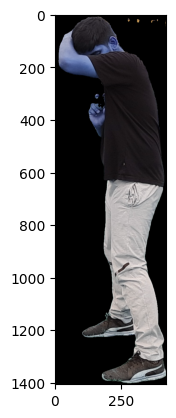

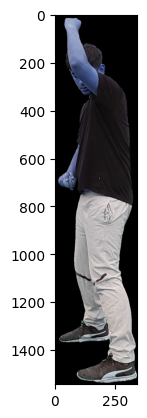

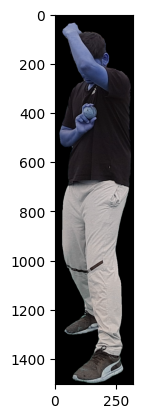

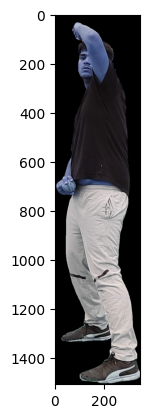

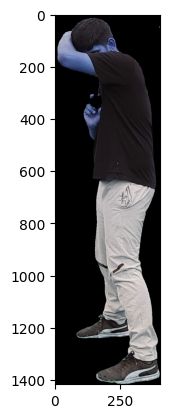

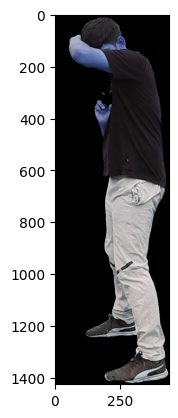

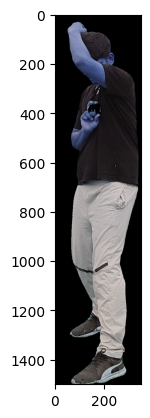

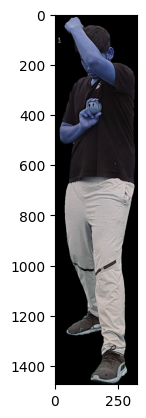

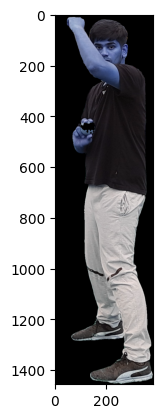

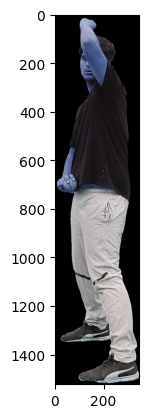

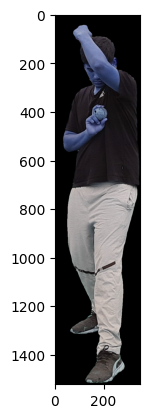

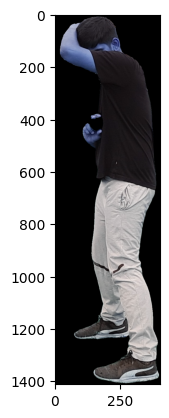

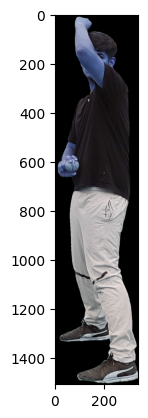

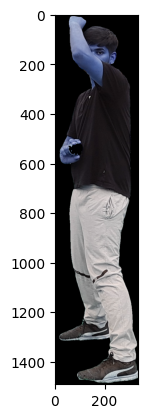

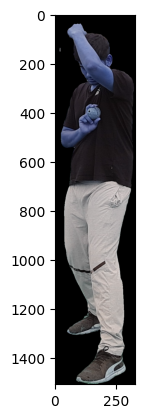

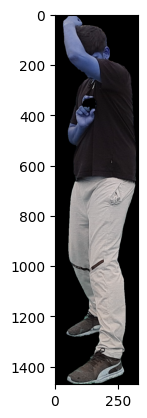

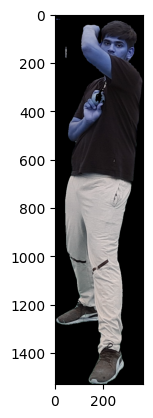

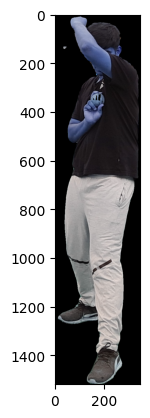

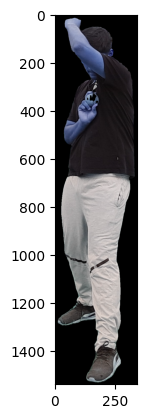

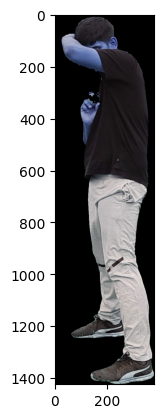

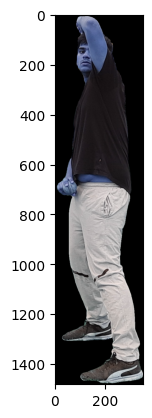

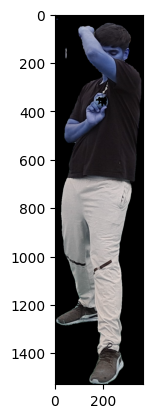

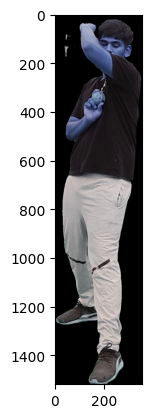

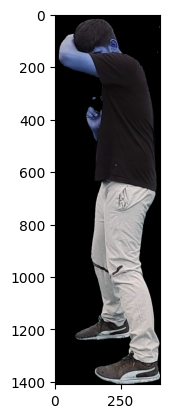

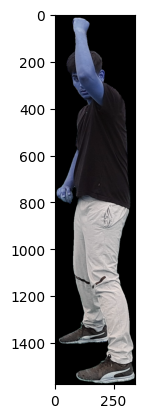

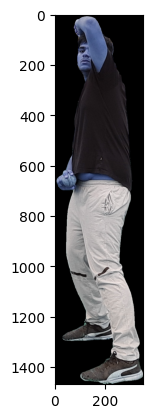

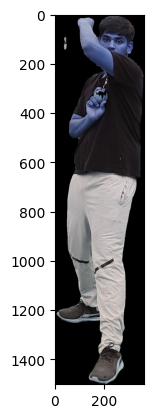

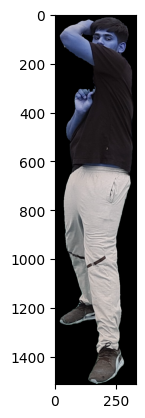

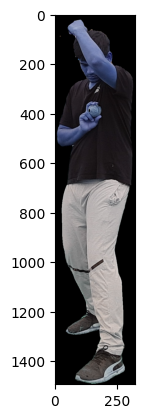

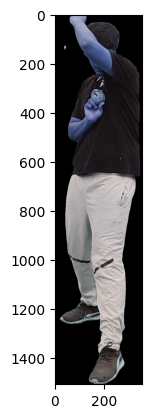

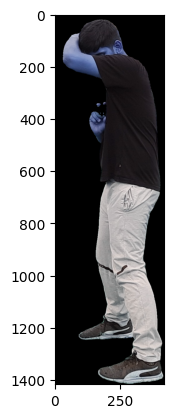

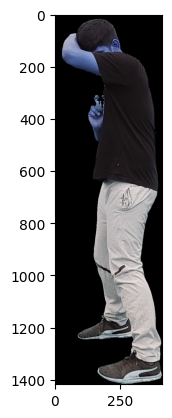

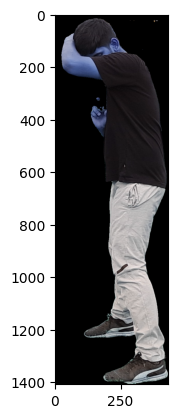

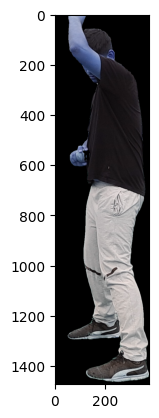

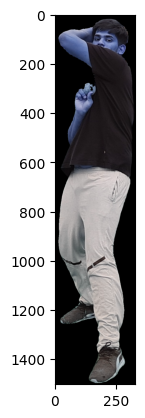

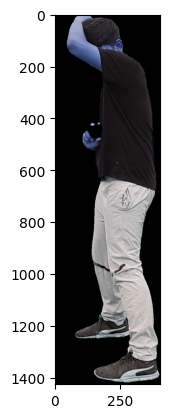

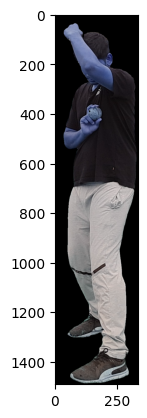

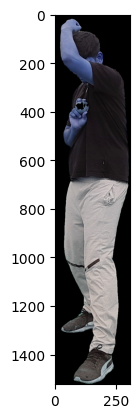

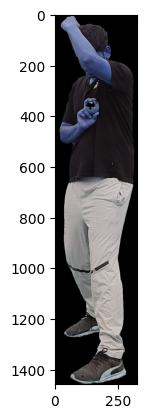

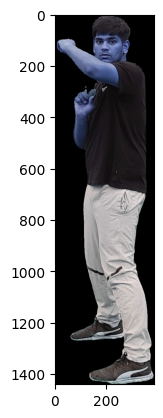

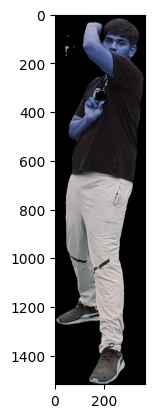

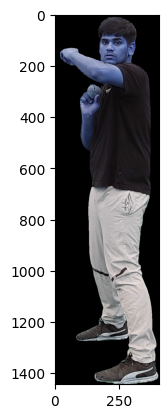

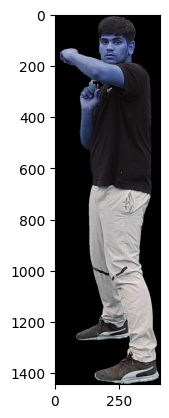

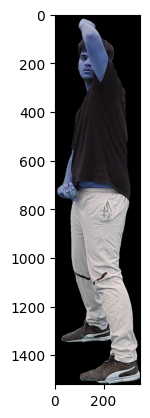

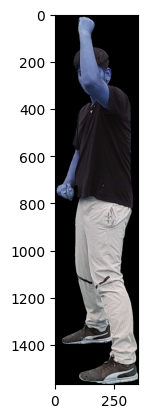

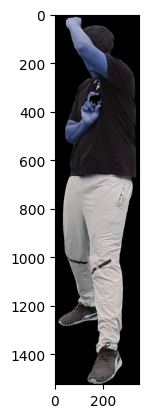

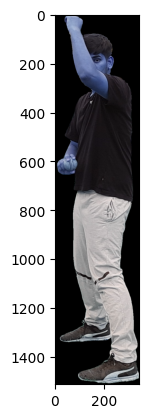

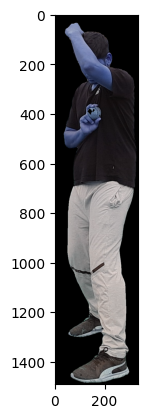

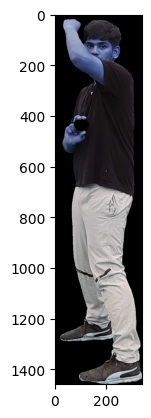

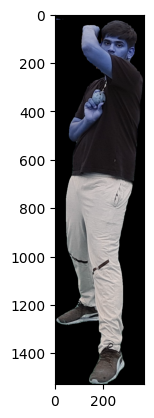

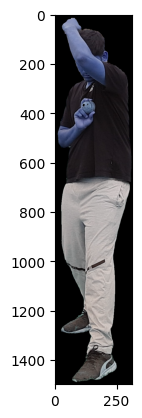

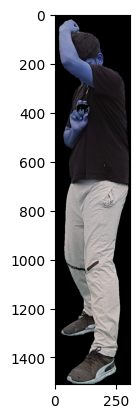

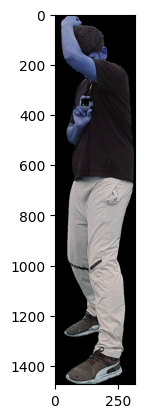

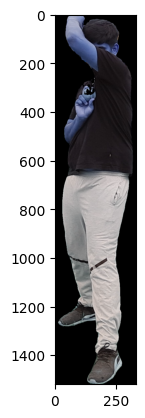

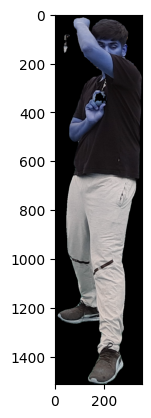

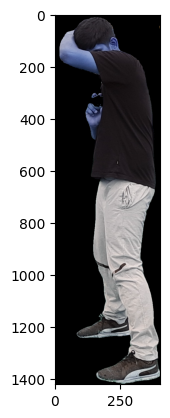

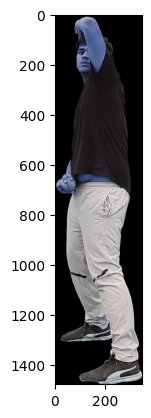

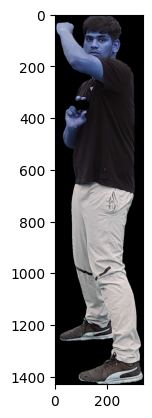

In [43]:
import matplotlib.pyplot as plt

for key in img_dict:
    for image in img_dict[key]:
        plt.imshow(image)
        plt.show()
    break